#Description
This data wrangling will be broken up into many parts.
1. PCPAO_SalesDATA

*   [Import Data](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=bhFix5o66a2r&line=1&uniqifier=1)
*   [Drop data that isn't single-family home(or condos in the future)](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=m_76SnpKLHBW&line=1&uniqifier=1).
*   [Convert sales_date into datetime type](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=ny5FtX-3MdPm&line=1&uniqifier=1)
*   [Limit data to most recent sale of each property](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=B4DNHYVou_eY&line=1&uniqifier=1)
*   [Drop repeated address data and owner names](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=xHe6LbEo7vTJ&line=1&uniqifier=1)
*   [Frontage, View, Landsize, Acreage, and QU_FLG are dropped](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=ZMQPKQcvG9kB&line=1&uniqifier=1)
*   [House Features are cleaned and converted to categories](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=-uujdrVuGqjW&line=1&uniqifier=1)
*   [County Designations are converted to categories or dropped](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=n6_yayeoHrOz&line=1&uniqifier=1)
*   [Subdivisions are examined and dropped](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=LXGKW5FRIn4N&line=1&uniqifier=1)
*   [Examining dataset and dropping rows with missing values](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=7Gkodmd6IxlK&line=1&uniqifier=1)
*   [Dropping Parcel Number and Site Address Columns](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=BJ9QVzyAI-5J&line=1&uniqifier=1)
*   [Converting Site_Cityzip and remaining object columns to categories](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=VbUcsxenJRqY&line=1&uniqifier=1)
*   [Dropping sales data prior to 1970](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=WUSNh7bDE299&line=1&uniqifier=1)
*   [Making a dataframe of 2016-to-present sales](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=qxGQjv88JqpM&line=1&uniqifier=1)

Future steps will be done to this data set involve its pairing with the data sets below.

2. PinellasCrimeDATA

This data is a collection of csv files downloaded from FILL IN LOCATION HERE. The goal with this data is to generate totals and average yearly crime stats relative to each ZIP code and possibly neighborhood code.

3. School_gradeDATA

This data is yet to be collected from the FL DOE website.


[4. Export the data](https://colab.research.google.com/drive/1f6dAlQb4MGhezrfQXVxswkWafBDRJg_v#scrollTo=AyfXeiJD1ZZ7&line=1&uniqifier=1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#1. PCPAO_SalesDATA


###Importing Data

Import the data from the csv.

In [2]:
PCPAO_SalesDATA = pd.read_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Raw_Data/PCPAOSalesDATA.csv',low_memory=False)

In [3]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155164 entries, 0 to 1155163
Data columns (total 54 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   PARCEL_NUMBER        1155164 non-null  object 
 1   OWNER1               1155134 non-null  object 
 2   OWNER2               624705 non-null   object 
 3   SITE_ADDRESS         1155160 non-null  object 
 4   SITE_CITYZIP         1155164 non-null  object 
 5   SUBDIVISION          1147546 non-null  object 
 6   LAND_SIZE            760559 non-null   object 
 7   TOTAL_LIVING_SQFT    1155156 non-null  float64
 8   TOTAL_GROSS_SQFT     1155156 non-null  float64
 9   NBORHOOD_CD          1155164 non-null  float64
 10  YEAR_BUILT_BLD1      1155098 non-null  float64
 11  TOTAL_LIVING_UNITS   1155156 non-null  float64
 12  ACREAGE              1155164 non-null  float64
 13  CNTY_JST_VALUE       1155164 non-null  int64  
 14  CNTY_ASD_VALUE       1155164 non-null  int64  
 15

###Dropping data that isn't about '0110 Single Family Home's.

Since all of the data is '0110 Single Family Home', dropping the PROPERTY_USE and PARCEL_TYPE columns.

In [4]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['PROPERTY_USE'] == '0110 Single Family Home']
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['PROPERTY_USE','PARCEL_TYPE'],axis=1)

###Converting the SALES_DATE to a datetime data type.

In [5]:
PCPAO_SalesDATA['SALES_DATE'] = pd.to_datetime(PCPAO_SalesDATA['SALES_DATE'],format='%m/%d/%Y %I:%M:%S %p')


###Limiting the data to the most recent sale of each Parcel

I want to keep the sales data for only the most recent sale of each property.

In [6]:
PCPAO_SalesDATA.sort_values(by='SALES_DATE',inplace=True)
PCPAO_SalesDATA.drop_duplicates(subset='PARCEL_NUMBER',keep='last',inplace=True)
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)

In [7]:
PCPAO_SalesDATA.head().T

,0,1,2,3,4
PARCEL_NUMBER,05-31-16-46116-020-0030,13-31-16-72504-001-0160,28-31-16-67338-026-0130,19-30-15-99342-006-0110,36-27-15-89334-000-0090
OWNER1,"PENTTINEN, GERALDINE L","VOGT, RONALD CHARLES","COONEY, ANN SHAW","BRUSKO, RYAN DAVID","LYON, YVONNE EYNON TRE"
OWNER2,NaN,"VOGT, TINA MARIE",NaN,NaN,"LYON, MARLENE ADELE TRE"
SITE_ADDRESS,6146 51ST AVE N,737 11TH ST N,5521 20TH AVE S,14066 STARBOARD DR,3025 LEPRECHAUN LN
SITE_CITYZIP,"KENNETH CITY, FL 33709","ST PETERSBURG, FL 33705","GULFPORT, FL 33707","SEMINOLE, FL 33776","PALM HARBOR, FL 34683"
SUBDIVISION,KENNETH CITY UNIT 7,"POMEROY'S ADD, J.B.",PASADENA GARDENS GULFVIEW SEC,YACHT CLUB ESTATES UNIT 6,TAMPA & TARPON SPRINGS LAND CO
LAND_SIZE,75x100,40x125,100x127,82x105,0x0
TOTAL_LIVING_SQFT,1281.0,920.0,768.0,1658.0,2721.0
TOTAL_GROSS_SQFT,2403.0,1238.0,1514.0,2180.0,3519.0
NBORHOOD_CD,407.0,1106.0,1304.0,608.0,1914.0


###Dropping repeated address information and owner names

From previous exploration, SITE_ADDRESS and SITE_CITYZIP matchup well enough with all of the STR_PFX, STR_NUM, STR_NAME, STR_SFX, STR_SFX_DIR, STR_CITY, and STR_ZIP, that I will drop all of the address data except for SITE_ADDRESS and SITE_CITYZIP.

This step might be undone in the future

In [8]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['STR_PFX','STR_NUM','STR_NAME','STR_SFX','STR_SFX_DIR','STR_CITY','STR_ZIP'],axis=1)

Dropping OWNER1 OWNER2

In [9]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['OWNER1','OWNER2'],axis=1)

###

In [10]:
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   SUBDIVISION          217182 non-null  object        
 4   LAND_SIZE            219356 non-null  object        
 5   TOTAL_LIVING_SQFT    219367 non-null  float64       
 6   TOTAL_GROSS_SQFT     219367 non-null  float64       
 7   NBORHOOD_CD          219367 non-null  float64       
 8   YEAR_BUILT_BLD1      219350 non-null  float64       
 9   TOTAL_LIVING_UNITS   219367 non-null  float64       
 10  ACREAGE              219367 non-null  float64       
 11  CNTY_JST_VALUE       219367 non-null  int64         
 12  CNTY_ASD_VALUE       219367 non-null  int64         
 13  CNTY_TAXABLE_V

###Frontage, Views, Landsize, Acreage, and QU_FLG columns are dropped

So far the dataset has been reduced by about 400 MB in terms of memory, and 11 columns gave been dropped.

FRONTAGE and VIEWS are two columns containing a lot of null data. Going to drop them.

In [11]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['FRONTAGE','VIEWS'],axis=1)

LAND_SIZE is the description of each lot's length and width. This might be nice to have in the future to create a measure of the lot's squareness, but for now will be dropped.

In [12]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['LAND_SIZE'],axis=1)

LAND_AREA_SF and ACREAGE are 100% correlated from previous exploration, so I will just drop the ACREAGE column as the LAND_AREA_SF might be useful if I want to create ratios of total_living_sqft to land_area_sf.

In [13]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['ACREAGE'],axis=1)

Also going to drop the QU_FLG as all of the sales should be qualified.

In [14]:
PCPAO_SalesDATA= PCPAO_SalesDATA.drop(['QU_FLG'],axis=1)

In [15]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 38 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   SUBDIVISION          217182 non-null  object        
 4   TOTAL_LIVING_SQFT    219367 non-null  float64       
 5   TOTAL_GROSS_SQFT     219367 non-null  float64       
 6   NBORHOOD_CD          219367 non-null  float64       
 7   YEAR_BUILT_BLD1      219350 non-null  float64       
 8   TOTAL_LIVING_UNITS   219367 non-null  float64       
 9   CNTY_JST_VALUE       219367 non-null  int64         
 10  CNTY_ASD_VALUE       219367 non-null  int64         
 11  CNTY_TAXABLE_VALUE   219367 non-null  int64         
 12  TAX_DIST_DSCR        219352 non-null  object        
 13  SPECIAL_ASSESS

###House Features are cleaned and converted to categories

Many features of the physical property are recorded as string objects. Lucky most of them are non-null.


Going to convert the following columns to categories.
*  COOLING
*  EXTERIOR_WALLS
*  FLOOR_FINISH
*  FLOOR_SYSTEM
*  FOUNDATION
*  INTERIOR_FINISH
*  ROOF_COVER
*  ROOF_FRAME

COOLING needs some nan values converted into 'No Central Cooling'

In [16]:
PCPAO_SalesDATA.loc[PCPAO_SalesDATA['COOLING'].isnull(),'COOLING'] = 'No Central Cooling'

In [17]:
col_to_cat = ['COOLING','EXTERIOR_WALLS','FLOOR_FINISH','FLOOR_SYSTEM','FOUNDATION','INTERIOR_FINISH','ROOF_COVER','ROOF_FRAME']
for col in col_to_cat:
  PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].astype('category')

###County Designations(Historic Land, Neighborhood code, Tax District)

DLHL_YN is for whether the property is a designated local historical landmark. 86 records are for properties that are a designated local historical landmark and 219,281 rows are not. I will make this column to a category type. This column will be dropped if all the 86 records end up removed at the end.

In [18]:
PCPAO_SalesDATA['DLHL_YN'].value_counts()

,count
DLHL_YN,
N,219281
Y,86


In [19]:
PCPAO_SalesDATA['DLHL_YN'] = PCPAO_SalesDATA['DLHL_YN'].astype('category')

NBORHOOD_CD is currently a float when it should be categorical.

[Neighborhood Code ](https://www.pcpao.gov/learn-about/glossary-terms/n)- This code identifies the appraisal "neighborhood" for purposes of establishing the sales comparison approach to value. It may not correspond with your particular subdivision or geographic neighborhood; it is strictly developed for use in the mass appraisal process. When establishing the sales comparison approach to value we use an appraisal area model to obtain an estimate of value. The model can include hundreds of sales. We then review a subset of sales more closely identified with a particular property, referred to as the appraisal neighborhood. We give the greatest emphasis to sales within the appraisal neighborhood through use of a neighborhood "factor." Through statistical analysis of all of these sales, we establish sales comparison values that account for different property characteristics (such as location, size, amenities, construction quality, view, etc.).

In [20]:
PCPAO_SalesDATA['NBORHOOD_CD'] = PCPAO_SalesDATA['NBORHOOD_CD'].astype('category')

TAX_DIST_DSCR is the description of the tax district. Going to drop that.

In [21]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['TAX_DIST_DSCR'],axis=1)

###Subdivions are examined and dropped

Thinking about SUBDIVISION here. There are 6,114 named subdivisions. These subdivisions cover all but 2185 properties. 377 properties are their own subdivision.

Going to drop this column for now. I hoped it would work as a replacement for the neighborhood column. Maybe it could.

I could create a subdivision_size column that categorizes the properties by the size of the subdivision. Not sure of the benefit. I am not sure where the NaN subdivision properties would fall, but a 'No listed subdivision' would be the largest subdivision category.

In [22]:
PCPAO_SalesDATA['SUBDIVISION'].isnull().sum()

2185

In [23]:
PCPAO_SalesDATA['SUBDIVISION'].value_counts()

,count
SUBDIVISION,
NORTH ST PETERSBURG,777
ORANGE LAKE VILLAGE,691
PINELLAS GROVES,653
"SUTHERLAND, TOWN OF",606
DUNEDIN ISLES NO. 1,544
...,...
PORACH'S ADD NO. 3,1
"BRUNNER, E. J.",1
BAHIA VISTA 1ST ADD,1


In [24]:
subdivision_counts = PCPAO_SalesDATA['SUBDIVISION'].value_counts()
single_subdivisions = subdivision_counts[subdivision_counts <= 1]

In [25]:
subdivision_counts.groupby(subdivision_counts.values).size()

,count
1,337
2,334
3,231
4,183
5,182
...,...
544,1
606,1
653,1
691,1


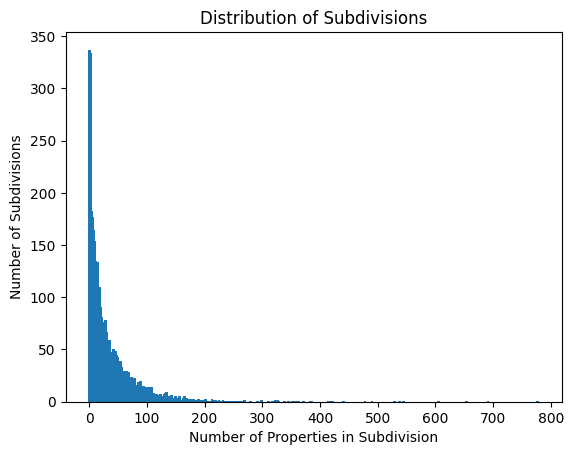

In [26]:
x=subdivision_counts.groupby(subdivision_counts.values).size().index
y=subdivision_counts.groupby(subdivision_counts.values).size().values

plt.bar(x=x,height=y,width=5)
plt.title('Distribution of Subdivisions')
plt.xlabel('Number of Properties in Subdivision')
plt.ylabel('Number of Subdivisions')
plt.show()

In [27]:
single_subdivisions

,count
SUBDIVISION,
DONNA'S REPLAT,1
GROVEMONT SUB'N NO. 2 YATES REPLAT,1
HUGHES - PEARSON REPLAT,1
LAKE JUDY SUB,1
MAPLE LEAF FARMS SUB,1
...,...
PORACH'S ADD NO. 3,1
"BRUNNER, E. J.",1
BAHIA VISTA 1ST ADD,1


In [28]:
PCPAO_SalesDATA = PCPAO_SalesDATA.drop(['SUBDIVISION'],axis=1)

###Examining dataset and dropping rows missing values

In [29]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219367 entries, 0 to 219366
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219367 non-null  object        
 1   SITE_ADDRESS         219366 non-null  object        
 2   SITE_CITYZIP         219367 non-null  object        
 3   TOTAL_LIVING_SQFT    219367 non-null  float64       
 4   TOTAL_GROSS_SQFT     219367 non-null  float64       
 5   NBORHOOD_CD          219367 non-null  category      
 6   YEAR_BUILT_BLD1      219350 non-null  float64       
 7   TOTAL_LIVING_UNITS   219367 non-null  float64       
 8   CNTY_JST_VALUE       219367 non-null  int64         
 9   CNTY_ASD_VALUE       219367 non-null  int64         
 10  CNTY_TAXABLE_VALUE   219367 non-null  int64         
 11  SPECIAL_ASSESSMENT   219352 non-null  float64       
 12  JUST_LAND            219367 non-null  int64         
 13  JUST_BUILDING 

Looking at the dataset now, I feel like I can drop the rows that are missing any values because most of the data will remain.

In [30]:
PCPAO_SalesDATA.dropna(inplace=True)
PCPAO_SalesDATA.reset_index(drop=True,inplace=True)
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219081 entries, 0 to 219080
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PARCEL_NUMBER        219081 non-null  object        
 1   SITE_ADDRESS         219081 non-null  object        
 2   SITE_CITYZIP         219081 non-null  object        
 3   TOTAL_LIVING_SQFT    219081 non-null  float64       
 4   TOTAL_GROSS_SQFT     219081 non-null  float64       
 5   NBORHOOD_CD          219081 non-null  category      
 6   YEAR_BUILT_BLD1      219081 non-null  float64       
 7   TOTAL_LIVING_UNITS   219081 non-null  float64       
 8   CNTY_JST_VALUE       219081 non-null  int64         
 9   CNTY_ASD_VALUE       219081 non-null  int64         
 10  CNTY_TAXABLE_VALUE   219081 non-null  int64         
 11  SPECIAL_ASSESSMENT   219081 non-null  float64       
 12  JUST_LAND            219081 non-null  int64         
 13  JUST_BUILDING 

###Dropping Parcel Number and Site Address Columns

All the parcel numbers should be unique identifiers since we limited the records to the most recent sale of each parcel. I am not aware of any rules determining parcel numbers, so I will drop them. I will also drop the site address as I don't want to train a model to predict the housing price based on its specific address.


In [31]:
PCPAO_SalesDATA.drop(['PARCEL_NUMBER'],axis=1,inplace=True)

In [32]:
PCPAO_SalesDATA.drop(['SITE_ADDRESS'],axis=1,inplace=True)

###Converting Site_Cityzip and remaining object columns to categories

The SITE_CITYZIP is currently the best location identifier. There are only 86 unique cityzip combinations. Some cityzips have thousands of parcels while some cityzips have only one parcel. This is a similar situation to the subdivisions but there were never any null cityzips.

In [33]:
PCPAO_SalesDATA['SITE_CITYZIP'].value_counts()

,count
SITE_CITYZIP,
"ST PETERSBURG, FL 33710",11519
"ST PETERSBURG, FL 33713",10055
"DUNEDIN, FL 34698",9522
"PALM HARBOR, FL 34683",9249
"ST PETERSBURG, FL 33703",8306
...,...
"TIERRA VERDE, FL 33773",1
"OLDSMAR, FL 34695",1
"INDIAN ROCKS BEACH, FL 33786",1


In [34]:
PCPAO_SalesDATA['SITE_CITYZIP']=PCPAO_SalesDATA['SITE_CITYZIP'].astype('category')

Going to convert any remaining object types into categories.

In [35]:
for col in PCPAO_SalesDATA.columns:
  if PCPAO_SalesDATA[col].dtype == 'object':
    PCPAO_SalesDATA[col] = PCPAO_SalesDATA[col].astype('category')

In [36]:
PCPAO_SalesDATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219081 entries, 0 to 219080
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   SITE_CITYZIP         219081 non-null  category      
 1   TOTAL_LIVING_SQFT    219081 non-null  float64       
 2   TOTAL_GROSS_SQFT     219081 non-null  float64       
 3   NBORHOOD_CD          219081 non-null  category      
 4   YEAR_BUILT_BLD1      219081 non-null  float64       
 5   TOTAL_LIVING_UNITS   219081 non-null  float64       
 6   CNTY_JST_VALUE       219081 non-null  int64         
 7   CNTY_ASD_VALUE       219081 non-null  int64         
 8   CNTY_TAXABLE_VALUE   219081 non-null  int64         
 9   SPECIAL_ASSESSMENT   219081 non-null  float64       
 10  JUST_LAND            219081 non-null  int64         
 11  JUST_BUILDING        219081 non-null  int64         
 12  JUST_EXTRA_FEATURES  219081 non-null  int64         
 13  SALES_DATE    

###Dropping data that has a sales date prior to 1970.

In [37]:
PCPAO_SalesDATA = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=1970].reset_index(drop=True)

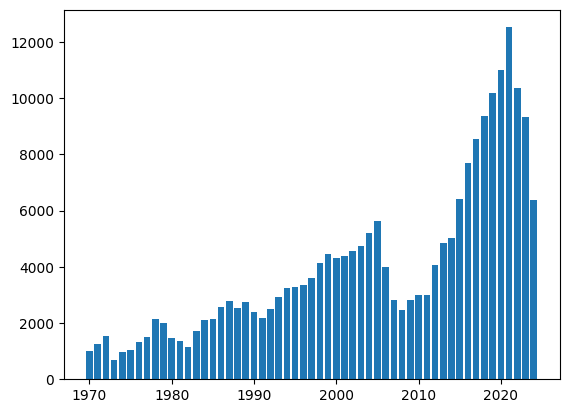

In [38]:
sales_date_count = PCPAO_SalesDATA['SALES_DATE'].dt.year.value_counts().reset_index()
x = sales_date_count['SALES_DATE']
y = sales_date_count['count']
plt.bar(x=x,height=y)
plt.show()


This graph matches one seen in earlier data exploration. Now I will just collect sales since 2016

###Making a dataframe of data from 2016 to present

In [39]:
sales16 = PCPAO_SalesDATA[PCPAO_SalesDATA['SALES_DATE'].dt.year>=2016].reset_index(drop=True)
sales16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85396 entries, 0 to 85395
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SITE_CITYZIP         85396 non-null  category      
 1   TOTAL_LIVING_SQFT    85396 non-null  float64       
 2   TOTAL_GROSS_SQFT     85396 non-null  float64       
 3   NBORHOOD_CD          85396 non-null  category      
 4   YEAR_BUILT_BLD1      85396 non-null  float64       
 5   TOTAL_LIVING_UNITS   85396 non-null  float64       
 6   CNTY_JST_VALUE       85396 non-null  int64         
 7   CNTY_ASD_VALUE       85396 non-null  int64         
 8   CNTY_TAXABLE_VALUE   85396 non-null  int64         
 9   SPECIAL_ASSESSMENT   85396 non-null  float64       
 10  JUST_LAND            85396 non-null  int64         
 11  JUST_BUILDING        85396 non-null  int64         
 12  JUST_EXTRA_FEATURES  85396 non-null  int64         
 13  SALES_DATE           85396 non-

In [40]:
sales16['SALES_DATE'].dt.year.value_counts()

,count
SALES_DATE,
2021,12521
2020,11017
2022,10364
2019,10179
2018,9376
2023,9323
2017,8558
2016,7676
2024,6382


#4. Exporting Data

Here I will export the cleaned data for the PCPAO_SalesDATA and for sales16 into their own csv files.

In [41]:
PCPAO_SalesDATA.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/PCPAO_SalesDATA_cleaned.csv',index=False)

In [42]:
sales16.to_csv('/content/drive/MyDrive/Data Science Course/Capstone Work/Cleaned_Data/sales16_cleaned.csv',index=False)